# data preprocessing

In [23]:
import re
import pickle
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from soynlp.normalizer import repeat_normalize
from PIL import Image

from utils import get_khaiii_api, load_json, pos_text, stemming_text
from tokenizer import Tokenizer


cfg = load_json("config.json")

In [2]:
api = get_khaiii_api('/mnt/subdisk/workspace/khaiii/build/share/khaiii')

In [7]:
df = pd.read_excel(cfg['output_dir'] + "/ine_coment.xlsx")
df.head()

,title,desc,name,time,comment
0,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,한량프로,2021-11-11 07:52:37,잘 먹고 건강만 해다오 ㅋㅋㅋㅋㅋㅋㅋㅋ
1,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,권재혁,2021-11-11 07:51:59,호오... 아이네상... 꽤 높은 먹투력이군요...
2,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,릅릅,2021-11-11 07:49:29,0:51 백신맞고와서 뽀로로밴드 붙인거네ㅋㅋㅋ
3,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,이로운,2021-11-11 07:47:29,재밌는 영상 감사합니다 잘 볼게용
4,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,오월비 MayB,2021-11-11 07:47:26,아니 어떻게 트러플 머쉬룸 와퍼가 단종되지???!! 진짜 어이없네…


In [11]:
def normalize(text):
    text = text.replace("_x000D_", " ")
    text = text.replace("\n", " ")
    text = text.replace("넴", "님")
    text = text.replace("는데", "다")
    text = text.replace("아니네", "아이네")
    text = text.replace("해미네", "햄이네")
    text = re.sub("http[s]?://(?:[a-zA-Z]|[0-9]|[$\-@\.&+:/?=]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", "", text)
    text = re.sub(r'\d+(:\d+)+|[^ 가-힣0-9]', r' ', text)
    text = repeat_normalize(text, 3)
    text = re.sub(r'(.{3,}?)\1+', r'\1', text)
    return text.strip()

df = df[df['name'] != '아이네 INE']
df['comment'] = df['comment'].apply(normalize)
df = df[df['comment'].str.len() > 1]
df.head(5)

,title,desc,name,time,comment
0,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,한량프로,2021-11-11 07:52:37,잘 먹고 건강만 해다오
1,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,권재혁,2021-11-11 07:51:59,호오 아이네상 꽤 높은 먹투력이군요
2,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,릅릅,2021-11-11 07:49:29,백신맞고와서 뽀로로밴드 붙인거네
3,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,이로운,2021-11-11 07:47:29,재밌는 영상 감사합니다 잘 볼게용
4,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,오월비 MayB,2021-11-11 07:47:26,아니 어떻게 트러플 머쉬룸 와퍼가 단종되지 진짜 어이없네


In [12]:
pos_tagged_corpus = pos_text(df.comment, api)
df['processed_comment'] = stemming_text(pos_tagged_corpus)

In [13]:
df['processed_comment']

0                          잘/MAG 먹다/VV 건강/NNG 하다/VV 오/NNG
1                 호오/NNP 아이네/NNP 상/NNG 꽤/MAG 높/VA 먹투력/NNG
2                          백신맞/NNG 뽀로로밴드/NNG 붙이다/VV 거/NNG
3                  재밌/VA 영상/NNG 감사하다/VV 잘/MAG 볼/NNG 용/NNG
4       어떻/VA 트/NNG 러다/VV 플/NNG 머쉬룸/NNG 와퍼/NNG 단종되다/VV...
                              ...                        
8268                                                     
8270                                      아이네/NNP 아이네/NNP
8271                                        앙/NNP 구독띠/NNG
8272                                                     
8273                          빠/NNB 당/NNG 아이네/NNP 파이팅/NNG
Name: processed_comment, Length: 7753, dtype: object

In [15]:
df['processed_comment'] = df['processed_comment'].apply(
    lambda x: ' '.join(
        [
            w.split('/')[0] 
            for w in x.split() 
            if w.split('/')[1] in ['NNG', 'NNP', 'VV', 'VA', 'MAG', 'MAJ']
        ]
    )
)
df = df[df['processed_comment'] != ""]
df.head()

,title,desc,name,time,comment,processed_comment
0,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,한량프로,2021-11-11 07:52:37,잘 먹고 건강만 해다오,잘 먹다 건강 하다 오
1,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,권재혁,2021-11-11 07:51:59,호오 아이네상 꽤 높은 먹투력이군요,호오 아이네 상 꽤 높 먹투력
2,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,릅릅,2021-11-11 07:49:29,백신맞고와서 뽀로로밴드 붙인거네,백신맞 뽀로로밴드 붙이다 거
3,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,이로운,2021-11-11 07:47:29,재밌는 영상 감사합니다 잘 볼게용,재밌 영상 감사하다 잘 볼 용
4,방송의 5할이 먹는 이야기,20210913. 20211024 아이네의 최애 버거는? 아이네 생방송: http...,오월비 MayB,2021-11-11 07:47:26,아니 어떻게 트러플 머쉬룸 와퍼가 단종되지 진짜 어이없네,어떻 트 러다 플 머쉬룸 와퍼 단종되다 진짜 어이없


# draw wordcloud

In [20]:
all_tokens = sum(df['processed_comment'].apply(lambda x: x.split()), [])

In [21]:
counter = Counter(all_tokens)

counter.most_common(10)

[('아이네', 1397),
 ('너무', 970),
 ('좋', 805),
 ('하다', 780),
 ('보다', 768),
 ('있다', 432),
 ('진짜', 420),
 ('킹아', 388),
 ('주다', 346),
 ('귀엽', 344)]

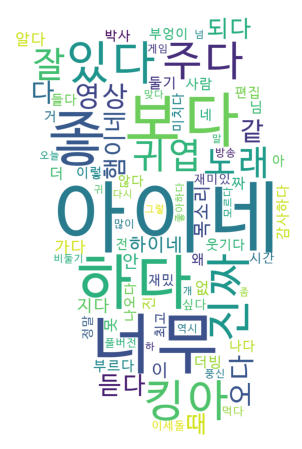

In [49]:
bgimg = Image.open('resource/wakdoo.png')
mask = np.array(bgimg)

wc = WordCloud(font_path=cfg['font_path'],background_color="white", max_font_size=200, mask=mask)
cloud = wc.generate_from_frequencies(dict(counter.most_common(80)))
cloud.to_file("resource/wordcloud.png")

plt.figure(figsize=(10, 8))
plt.axis('off')
plt.imshow(cloud)
plt.show()

# tokenizer

In [29]:
tokens = ["[PAD]", "[UNK]"] + [t[0] for t in counter.most_common(len(counter))]

with open("resource/tokenizer.pkl", "wb") as f:
    pickle.dump({k: i for i, k in enumerate(tokens)}, f)

In [30]:
tokenizer = Tokenizer("resource/tokenizer.pkl")

In [33]:
sample_text = df.iloc[0, -1]

print(sample_text)
print(tokenizer.encode(sample_text))

잘 먹다 건강 하다 오
[12, 62, 1257, 5, 125]
